# Text Analysis on Yahoo News Headlines

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
import lightgbm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
data=pd.read_csv('headlines.csv',parse_dates=True)

In [7]:
data.tail()

,publish_date,headline_category,headline_text
3297167,20200630,gadgets-news,why tiktok removed 1 65 crore videos in india
3297168,20200630,entertainment.hindi.bollywood,apurva asrani calls alia bhatts mother soni ra...
3297169,20200630,entertainment.hindi.bollywood,kangana ranaut gets a doll version of herself ...
3297170,20200630,entertainment.hindi.bollywood,meezaan jaffrey reminisces his childhood days ...
3297171,20200630,entertainment.telugu.movies.news,prabhas20 titled as radhe shyam prabhas and po...


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3297172 entries, 0 to 3297171
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 75.5+ MB


In [9]:
data.dropna(inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3297172 entries, 0 to 3297171
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 100.6+ MB


In [11]:
dataset=data.drop(['headline_category'],axis=1)
dataset.head()

,publish_date,headline_text
0,20010101,win over cena satisfying but defeating underta...
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa


In [12]:
dataset['publish_date']=pd.to_datetime(dataset['publish_date'],format='%Y%m%d')
dataset.head()


,publish_date,headline_text
0,2001-01-01,win over cena satisfying but defeating underta...
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa


In [13]:
dataset['headline_text']=dataset.groupby(['publish_date']).transform(lambda x:''.join(x))
dataset=dataset.drop_duplicates()
dataset

,publish_date,headline_text
0,2001-01-01,win over cena satisfying but defeating underta...
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
87,2001-01-03,Powerless north India gropes in the darkThink ...
128,2001-01-04,The string that pulled Stephen Hawking to Indi...
281,2001-01-05,Light combat craft takes India into club class...
...,...,...
3294593,2020-06-26,Containment zone residents slam high prices ch...
3295093,2020-06-27,like me i wont let you have a toxic relationsh...
3295620,2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...
3296120,2020-06-29,6 hot and stylish bikini looks of Katrina Kaif...


In [14]:
dataset['headline_text']

0          win over cena satisfying but defeating underta...
1          Status quo will not be disturbed at Ayodhya; s...
87         Powerless north India gropes in the darkThink ...
128        The string that pulled Stephen Hawking to Indi...
281        Light combat craft takes India into club class...
                                 ...                        
3294593    Containment zone residents slam high prices ch...
3295093    like me i wont let you have a toxic relationsh...
3295620    Atanu Ghosh plans to rewrite old scripts to ma...
3296120    6 hot and stylish bikini looks of Katrina Kaif...
3296636    Detective Byomkesh Bakshy!Edge of TomorrowFirs...
Name: headline_text, Length: 7080, dtype: object

In [27]:
dataset['headline_text'] = dataset['headline_text'].str.replace('[^a-zA-Z]', ' ')

In [28]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [29]:
dataset['Subjectivity']=dataset['headline_text'].apply(getSubjectivity)
dataset['Polarity']=dataset['headline_text'].apply(getPolarity)

In [37]:
dataset['headline_text'] = dataset['headline_text'].str.lower()
dataset['char_cnt'] = dataset['headline_text'].str.len()
dataset['word_cnt'] = dataset['headline_text'].str.split().str.len()

# Find the average length of word
dataset['avg_word_length'] = dataset['word_cnt']/ dataset['char_cnt']

dataset.head()

,publish_date,headline_text,Subjectivity,Polarity,text_clean,char_cnt,word_cnt,avg_word_length
0,2001-01-01,win over cena satisfying but defeating underta...,0.633333,0.433333,win over cena satisfying but defeating underta...,69,10,0.144928
1,2001-01-02,status quo will not be disturbed at ayodhya s...,0.262963,0.104630,status quo will not be disturbed at ayodhya s...,3238,489,0.151019
87,2001-01-03,powerless north india gropes in the darkthink ...,0.432500,0.107500,powerless north india gropes in the darkthink ...,1401,212,0.151320
128,2001-01-04,the string that pulled stephen hawking to indi...,0.511540,0.127977,the string that pulled stephen hawking to indi...,5703,828,0.145187
281,2001-01-05,light combat craft takes india into club class...,0.464036,0.255190,light combat craft takes india into club class...,4886,725,0.148383


In [39]:
dataset.drop(['text_clean'],inplace=True,axis=1)

Text(0.5, 1.0, 'Polarity in dataset')

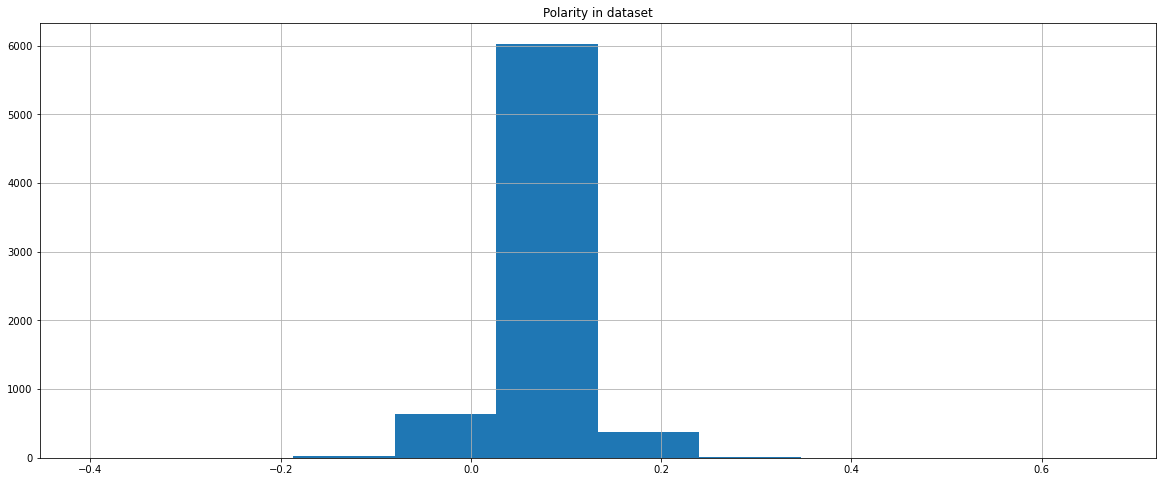

In [46]:
dataset['Polarity'].hist(figsize=(20,8))
plt.title('Polarity in dataset')

Text(0.5, 1.0, 'Subjectivity in dataset')

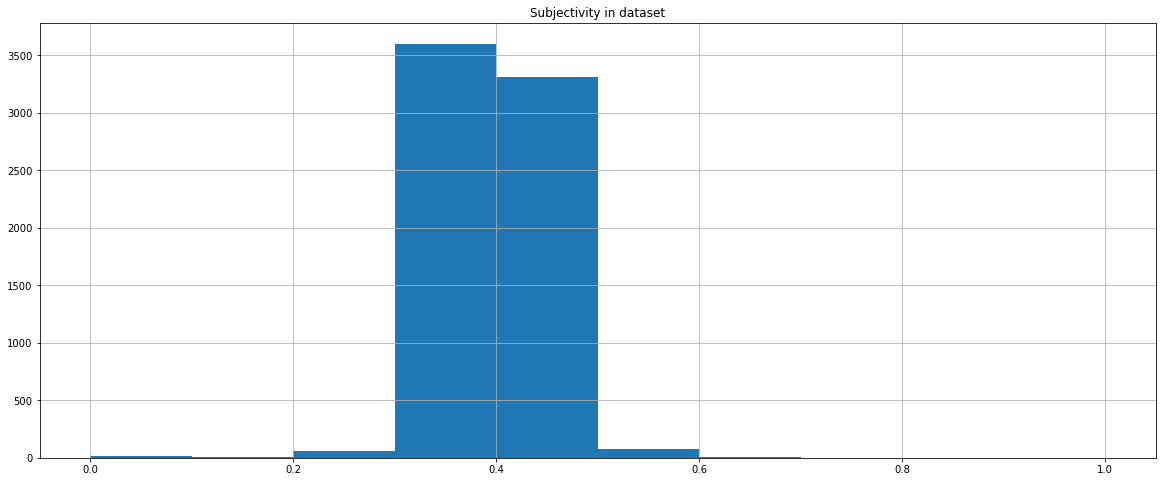

In [47]:
dataset['Subjectivity'].hist(figsize=(20,8))
plt.title('Subjectivity in dataset')

Text(0.5, 1.0, 'Character count in dataset')

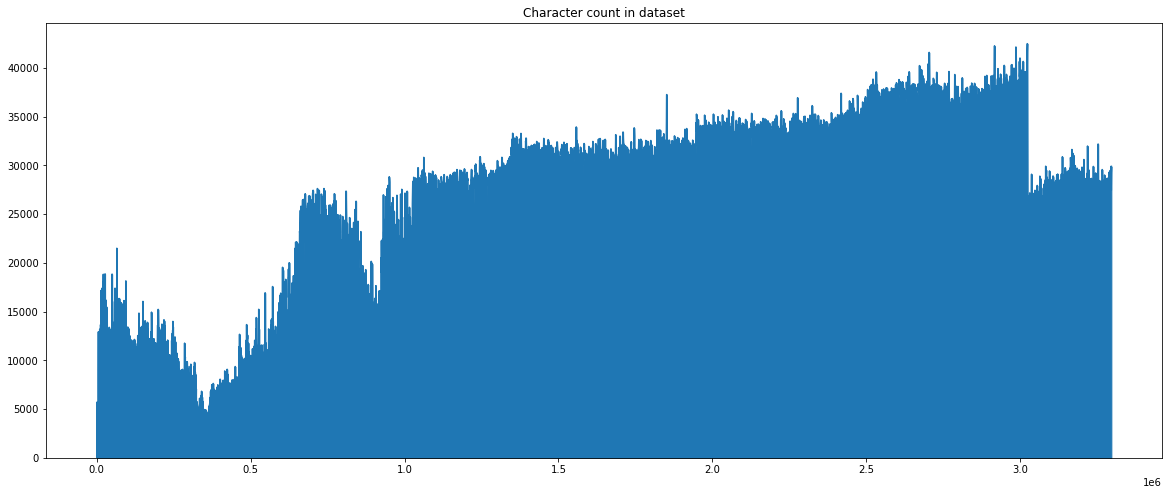

In [48]:
dataset['char_cnt'].plot.area(figsize=(20,8))
plt.title('Character count in dataset')

Text(0.5, 1.0, 'Word Count in Dataset')

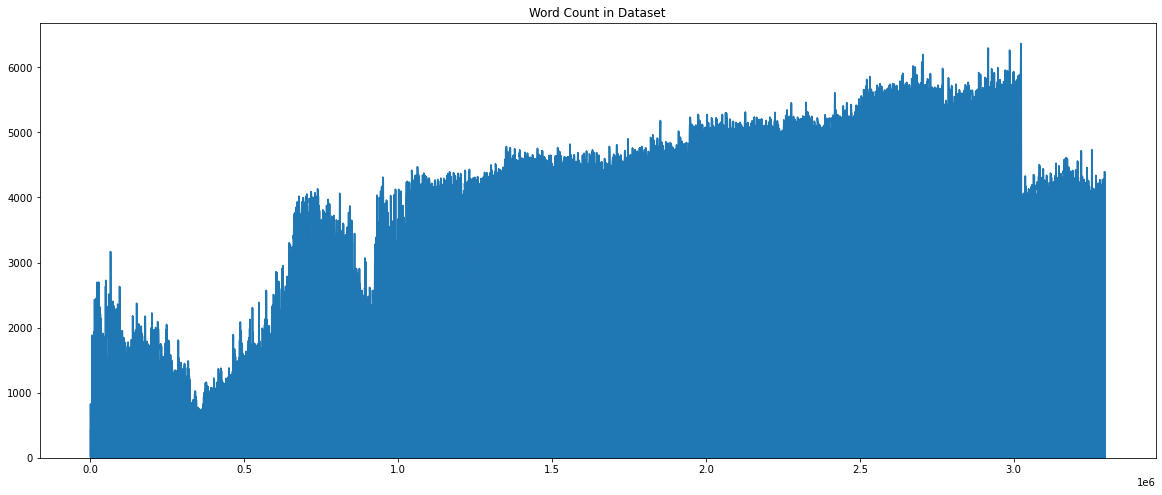

In [49]:
dataset['word_cnt'].plot.area(figsize=(20,8))
plt.title('Word Count in Dataset')

Text(0.5, 1.0, 'Average word length in dataset')

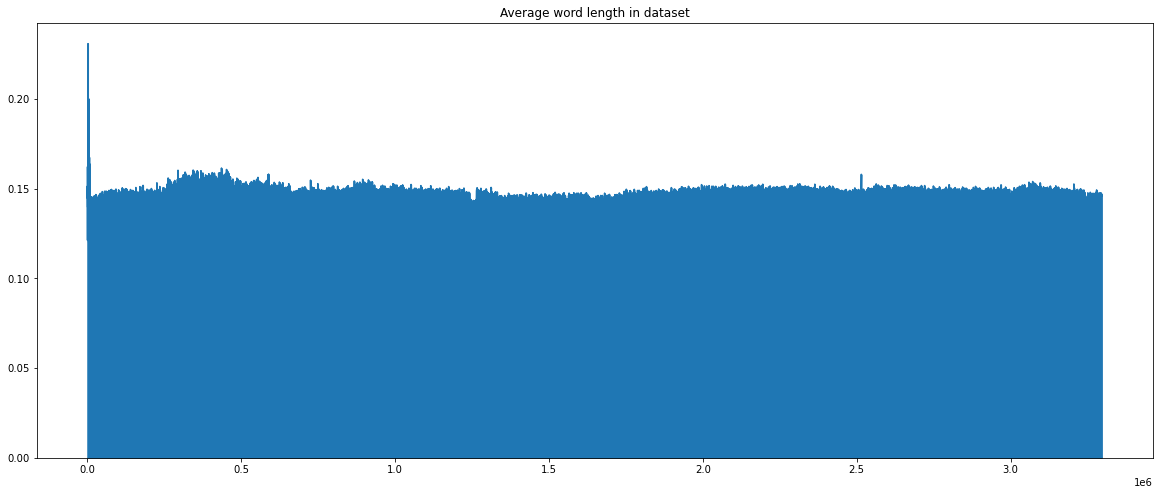

In [50]:
dataset['avg_word_length'].plot.area(figsize=(20,8))
plt.title('Average word length in dataset')

In [51]:
sia=SentimentIntensityAnalyzer()
dataset['Compound']=[sia.polarity_scores(v)['compound'] for v in dataset['headline_text']]
dataset['Negative']=[sia.polarity_scores(v)['neg'] for v in dataset['headline_text']]
dataset['Neutral']=[sia.polarity_scores(v)['neu'] for v in dataset['headline_text']]
dataset['Positive']=[sia.polarity_scores(v)['pos'] for v in dataset['headline_text']]
dataset.head()

,publish_date,headline_text,Subjectivity,Polarity,char_cnt,word_cnt,avg_word_length,Compound,Negative,Neutral,Positive
0,2001-01-01,win over cena satisfying but defeating underta...,0.633333,0.433333,69,10,0.144928,-0.0000,0.230,0.473,0.297
1,2001-01-02,status quo will not be disturbed at ayodhya s...,0.262963,0.104630,3238,489,0.151019,-0.9322,0.104,0.824,0.072
87,2001-01-03,powerless north india gropes in the darkthink ...,0.432500,0.107500,1401,212,0.151320,-0.5106,0.115,0.792,0.093
128,2001-01-04,the string that pulled stephen hawking to indi...,0.511540,0.127977,5703,828,0.145187,0.0717,0.096,0.816,0.088
281,2001-01-05,light combat craft takes india into club class...,0.464036,0.255190,4886,725,0.148383,0.9949,0.113,0.711,0.177


In [52]:
dataset

,publish_date,headline_text,Subjectivity,Polarity,char_cnt,word_cnt,avg_word_length,Compound,Negative,Neutral,Positive
0,2001-01-01,win over cena satisfying but defeating underta...,0.633333,0.433333,69,10,0.144928,-0.0000,0.230,0.473,0.297
1,2001-01-02,status quo will not be disturbed at ayodhya s...,0.262963,0.104630,3238,489,0.151019,-0.9322,0.104,0.824,0.072
87,2001-01-03,powerless north india gropes in the darkthink ...,0.432500,0.107500,1401,212,0.151320,-0.5106,0.115,0.792,0.093
128,2001-01-04,the string that pulled stephen hawking to indi...,0.511540,0.127977,5703,828,0.145187,0.0717,0.096,0.816,0.088
281,2001-01-05,light combat craft takes india into club class...,0.464036,0.255190,4886,725,0.148383,0.9949,0.113,0.711,0.177
...,...,...,...,...,...,...,...,...,...,...,...
3294593,2020-06-26,containment zone residents slam high prices ch...,0.370603,0.072293,27527,4051,0.147165,-0.9999,0.161,0.751,0.089
3295093,2020-06-27,like me i wont let you have a toxic relationsh...,0.380464,0.084433,29851,4398,0.147332,-0.9999,0.148,0.758,0.094
3295620,2020-06-28,atanu ghosh plans to rewrite old scripts to ma...,0.386141,0.074113,27476,4029,0.146637,-0.9998,0.137,0.788,0.076
3296120,2020-06-29,hot and stylish bikini looks of katrina kaif...,0.380647,0.056804,29290,4277,0.146023,-0.9997,0.130,0.784,0.086


Text(0.5, 1.0, 'Neutral Score')

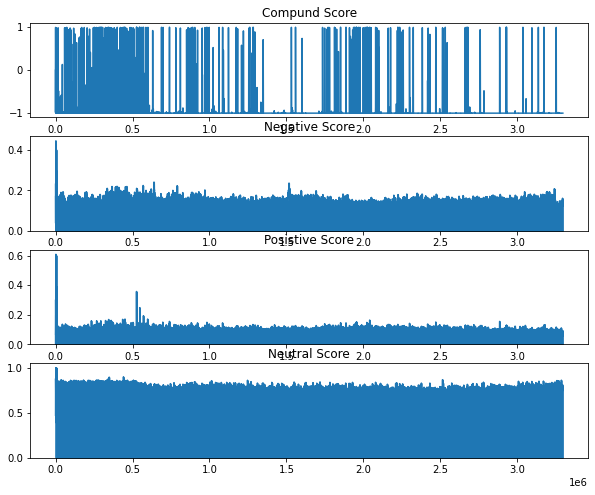

In [64]:
plt.figure(figsize=(10,8))
plt.subplot(4,1,1)
dataset['Compound'].plot()
plt.title('Compund Score')
plt.subplot(4,1,2)
dataset['Negative'].plot.area()
plt.title('Negative Score')
plt.subplot(4,1,3)
dataset['Positive'].plot.area()
plt.title('Posistive Score')
plt.subplot(4,1,4)
dataset['Neutral'].plot.area()
plt.title('Neutral Score')